## 0. Introduction

The aim of this notebook is to get familiar with **Neural Networks**.  

For this experiment, we will be using the [iris dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset).

## Neural Networks

Neural Networks (NN) are inspired by biological brains. Each "neuron" does a very simple calculation, however collectively they can do powerful computations.

A simple model neuron is called a Perceptron and is comprised of three components:
1. The weights
2. The input function
3. The activation function

perceptron.png

We can re-imagine the logistic regression unit as a neuron (function) that multiplies the input by the parameters (weights) and squashes the resulting sum through the sigmoid.

A Feed Forward NN will be a connected set of logistic regression units, arranged in layers. Each unit’s output is a non-linear function (e.g., sigmoid, step function) of a linear combination of its inputs.
 
We will use the sigmoid as an activation function.  

We use random parameter initialization in `LogisticRegression`, so that every hidden neuron will get a different input.
We do this in order for neurons to have different gradients during backpropagation and the network actually learns something. 

In [17]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import model_selection
from sklearn import datasets

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

import typing
%matplotlib inline

torch.manual_seed(0)

# 1. The XOR problem
 

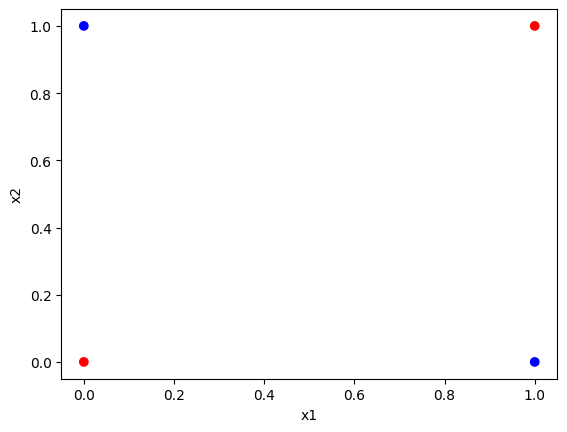

In [18]:
x1 = [0, 0, 1, 1]
x2 = [0, 1, 0, 1]
y = [0, 1, 1, 0]

c_map = ['r', 'b', 'b', 'r']
plt.scatter(x1, x2, c=c_map)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

### Logistic regression Class implementation

In [19]:
def sigmoid(z: torch.Tensor) -> torch.Tensor: 
  z = (1+ torch.exp(-z))**(-1)
  return z

def sigmoid_derivative(y):
      return y * (1-y) 


class LogisticRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(1, num_features), requires_grad=False)

  def forward(self, x):
    y = sigmoid( torch.matmul(x,self.weight.T) )     
    return y

The `NeuralNetwork` class below, supports outputs of any size. 

The theory of `backward_pass()` method is as follows:



*   **1)** For each output, $k$, calculate the partial derivative: $\delta_{k} = (y_{k}-t_{k}) \times g'(x_{k})$ 
where $y_{k}$ is the response of the output neuron and $t_{k}$ is the desired output (target). The derivative of the sigmoid function $g'(x_{k})$ is defined as $g'(x_{k}) = g(x_{k}) × (1 - g(x_{k}))$  
*  **2)** We now need to propagate this error to the hidden neurons. To accomplish this remember that: $
 \delta_{j} = g^\prime(x_{j}) \sum_{k} w_{jk} \delta_{k}
$  where $\delta_{j}$ is the error on the j-th hidden neuron,$x_{j}$ is the value of the hidden neuron (before it has been passed through the sigmoid function), $g^\prime$ is the derivative of the sigmoid function, $\delta_{k}$ is the error from the output neuron calculated in step 1, and $w_{jk}$ is the weight from the hidden neuron $j$ to the output neuron $k$.  

* **3)** We now need to update the output weights, i.e. the connections from the hidden neurons to the output neurons. This is accomplished using the formula: $
 w_{jk} = w_{jk} - \eta \delta_{k} \alpha_{j}
$ where $w_{jk}$ is the weight connecting the j-th hidden neuron to the k-th output neuron. $\alpha_{j}$ is the activity of the j-th hidden neuron (after it has been transformed by the sigmoid function), $\delta_{k}$ is the error from the output neuron stored in output\_deltas and $\eta$ is the learning rate  

* **4)**  Finally we need to update the hidden weights, i.e. the connections from the hidden neurons to the inputs. Here, again we use this equation $
 w_{ij} = w_{ij} - \eta \delta_{j} x_{i}
$ where $w_{ij}$ is the weight connecting the i-th input to the j-th hidden neuron. $x_{i}$ is the i-th input, $\delta_{j}$ is the backpropagated error (i.e., hidden deltas) from the j-th hidden neuron and $\eta$ is the learning rate.  

    

In [34]:
class NeuralNetwork(nn.Module):
  def __init__(self, num_inputs, num_neurons, num_outputs): 
    super().__init__()
    self.hidden_layer = nn.ModuleList([LogisticRegression(num_inputs) for _ in range(num_neurons)])
    self.output_layer = nn.ModuleList([LogisticRegression(num_neurons+1) for _ in range(num_outputs)]) # +1 for the bias
    
    self.num_inputs = num_inputs
    self.num_neurons = num_neurons
    self.num_outputs = num_outputs
    
  def forward(self, x: torch.tensor):
    y_hidden = torch.ones(len(self.hidden_layer) + 1) # +1 for the bias
    
    #hidden layer pass
    for i,neuron in enumerate(self.hidden_layer):
      y_hidden[i] = neuron(x)  #i to keep consistency with the input example below i.e. bias in last place 

    #output layer pass
    y_output = torch.tensor([neuron(y_hidden) for neuron in self.output_layer])

    return y_output


  def backward_pass(self, x: torch.tensor, y: torch.tensor, lr: float) -> None:
        
    y_pred = self.forward(x)
    y_hidden = torch.ones(len(self.hidden_layer) + 1)  
    
    for i,neuron in enumerate(self.hidden_layer):
      y_hidden[i] = neuron(x)  #i to keep consistency with the inputs below i.e. bias in last place
    

    ### Step 1 ###: Calculate the partial derivative wrt each output k. 
    errors = y_pred - y  
    delta_k = errors * sigmoid_derivative(y_pred)   #delta_k.shape = (num_outputs,1) 

    ### Step 2 ###: Propagate this error to hidden neurons. 
    delta_j = torch.zeros_like(y_hidden).unsqueeze(0)  # shape 1,3
    for k,neuron in enumerate(self.output_layer):  
        delta_j += neuron.weight * delta_k[k] 
    delta_j *= sigmoid_derivative(y_hidden)    

    ### Step 3 ###
    for k,neuron in enumerate(self.output_layer):    
        wght = neuron.weight
        wght -= lr * delta_k[k] * y_hidden
        neuron.weight = nn.Parameter(wght, requires_grad = False)
    
    ### Step 4 ### 
    delta_j = delta_j[:, :-1].squeeze(0)
    for j,neuron in enumerate(self.hidden_layer):   
        wght = neuron.weight
        wght -= lr * delta_j[j] * x
        neuron.weight = nn.Parameter(wght, requires_grad = False)
 
 
    return

### Example usage of the NeuralNetwork method

In [24]:
x_test = torch.tensor([0., 0., 1.]) # last value is the bias
y_test = torch.tensor([0.])
model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1)

print(model(x_test))
print(model)
for name, param in model.named_parameters():
  print(name, param)

print('\nHidden layer weight matrix:')
print(torch.stack(list(model.hidden_layer.parameters())))

model.backward_pass(x_test, y_test, 1)  

tensor([0.3747])
NeuralNetwork(
  (hidden_layer): ModuleList(
    (0-1): 2 x LogisticRegression()
  )
  (output_layer): ModuleList(
    (0): LogisticRegression()
  )
)
hidden_layer.0.weight Parameter containing:
tensor([[ 1.5410, -0.2934, -2.1788]])
hidden_layer.1.weight Parameter containing:
tensor([[ 0.5684, -1.0845, -1.3986]])
output_layer.0.weight Parameter containing:
tensor([[ 0.4033,  0.8380, -0.7193]])

Hidden layer weight matrix:
tensor([[[ 1.5410, -0.2934, -2.1788]],

        [[ 0.5684, -1.0845, -1.3986]]])


## Training the model on the XOR problem using appropriate hyperparameters

In [27]:
def bce(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
  
  cost = -( y_true*torch.log(y_pred) + (1-y_true)*torch.log(1-y_pred) ).mean()
  return cost 

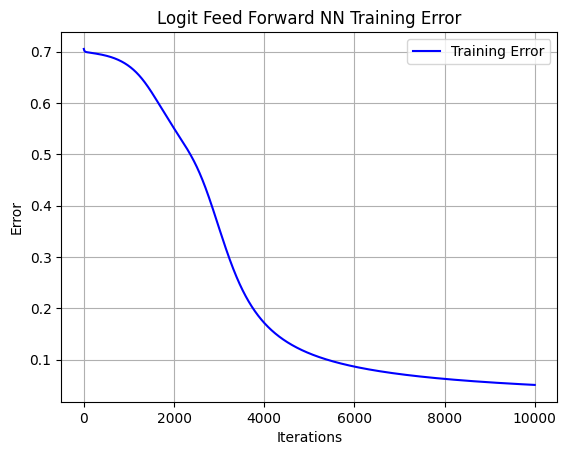

Actual values: tensor([0., 1., 1., 0.])
Predicted values: tensor([0.0430, 0.9522, 0.9524, 0.0605])


In [35]:
x1 = torch.tensor([0., 0., 1., 1.])
x2 = torch.tensor([0., 1., 0., 1.])
bias = torch.ones_like(x1)
x = torch.stack([x1, x2, bias]).permute(1, 0)
print( f'Input Matrix X has shape {x.shape}' )

y = torch.tensor([0., 1., 1., 0.])

lr = .1
iterations = 10000
model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1)
errors = []

# Training loop
for ep in range(iterations):
  error = 0
  if ep% int(iterations/10) == 0 :
    print( f'Iteration: {ep}')
  
  for i in range(x.shape[0]): 
    y_pred = model(x[i]) 
    error += bce(y[i], y_pred)
    model.backward_pass(x[i], y[i], lr)
  errors.append(error/x.shape[0])
display.clear_output(wait=True)


plt.plot(list(range(iterations)), errors, label='Training Error', color='b', linestyle='-')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Logit Feed Forward NN Training Error')
plt.legend(loc='upper right')  
plt.grid(True)
plt.show()

y_pred = torch.zeros_like(y)
for i in range(x.shape[0]):
    y_pred[i] = model(x[i])
 
print("Actual values:", y)
print("Predicted values:", y_pred)

# 2. Iris Dataset
We will now use pytorch built-in methods to create an MLP classifier for the iris dataset.

In [29]:
iris_db = datasets.load_iris(as_frame=True)
print(iris_db.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

Splitting the data to train and test sets and applying normalization.

In [30]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    iris_db.data,
    iris_db.target,
    test_size=0.2,
    random_state=42 
    )

x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).int()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test.values).int()
y_test = y_test.reshape(-1, 1)

def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor:
  return (x-mu)/sigma

mu_train = torch.mean(x_train, dim=0)
sigma_train = torch.std(x_train, dim=0)

x_train_normalized = norm_set(x_train, mu_train, sigma_train)
x_test_normalized = norm_set(x_test, mu_train, sigma_train)

# add a feature for bias
train_set_1 = torch.cat([x_train_normalized, torch.ones(x_train_normalized.shape[0], 1)], dim=1)
test_set_1 = torch.cat([x_test_normalized, torch.ones(x_test_normalized.shape[0], 1)], dim=1)
#observe we do not perform one-hot encoding as later we will not use binary_cross_entropy

Using pytorch built in methods we will build an MLP with one hidden layer. We train the network multiple times for the following number of hidden neurons `{1, 2, 4, 8, 16, 32}`.
 

In [31]:
def table_sumary(hidden_layers, test: bool, test_y, test_pred):
        softmax_output = F.softmax(test_pred, dim=1)
        test_tbl = pd.DataFrame(torch.cat([softmax_output, test_y], dim =1).detach().numpy(), columns= ['setosa_prob', 'versicolor_prob', 'virginica_prob', 'actual_class' ]) 
        test_tbl['actual_class'] = test_tbl['actual_class'].astype(int)

        label_map = {'setosa_prob': 0, 'versicolor_prob': 1, 'virginica_prob': 2} 

        test_tbl['predicted_class'] = test_tbl[['setosa_prob', 'versicolor_prob', 'virginica_prob']].idxmax(axis=1)
        test_tbl['predicted_class'] = test_tbl['predicted_class'].map(label_map) 
        test_tbl['correct_prediction'] = (test_tbl['actual_class'] == test_tbl['predicted_class'] ).astype(int)

        test_tbl['accuracy'] =  test_tbl['correct_prediction'].sum()/len(test_tbl)
        test_tbl['hidden_neurons'] = hidden_layers
        test_tbl['test'] = 'test_set' if test else 'train_set'
        test_tbl['model'] = 'MLP'

        return test_tbl[['model', 'hidden_neurons','test','accuracy']].iloc[0]
 

tensor([[-1.5662,  1.1829,  1.1328],
        [ 1.0984, -2.3281, -2.6540],
        [-1.5976,  1.2243,  1.1775],
        [-1.5599,  1.1745,  1.1238],
        [-1.5929,  1.2181,  1.1708],
        [ 1.0774, -2.3004, -2.6243],
        [-1.3100,  0.8453,  0.7687],
        [-1.5961,  1.2223,  1.1754],
        [-1.5963,  1.2226,  1.1756],
        [-1.5157,  1.1163,  1.0610],
        [-1.5880,  1.2117,  1.1639],
        [ 1.0834, -2.3083, -2.6328],
        [ 1.0953, -2.3240, -2.6497],
        [ 1.0864, -2.3123, -2.6370],
        [ 1.1060, -2.3381, -2.6649],
        [-1.5227,  1.1256,  1.0711],
        [-1.5963,  1.2226,  1.1756],
        [-1.5331,  1.1393,  1.0858],
        [-1.5302,  1.1355,  1.0817],
        [-1.5968,  1.2232,  1.1763],
        [ 1.0952, -2.3238, -2.6494],
        [-1.5808,  1.2021,  1.1536],
        [ 1.0928, -2.3206, -2.6461],
        [-1.5966,  1.2229,  1.1760],
        [-1.5955,  1.2215,  1.1745],
        [-1.5963,  1.2225,  1.1756],
        [-1.5974,  1.2240,  1.1771],
 

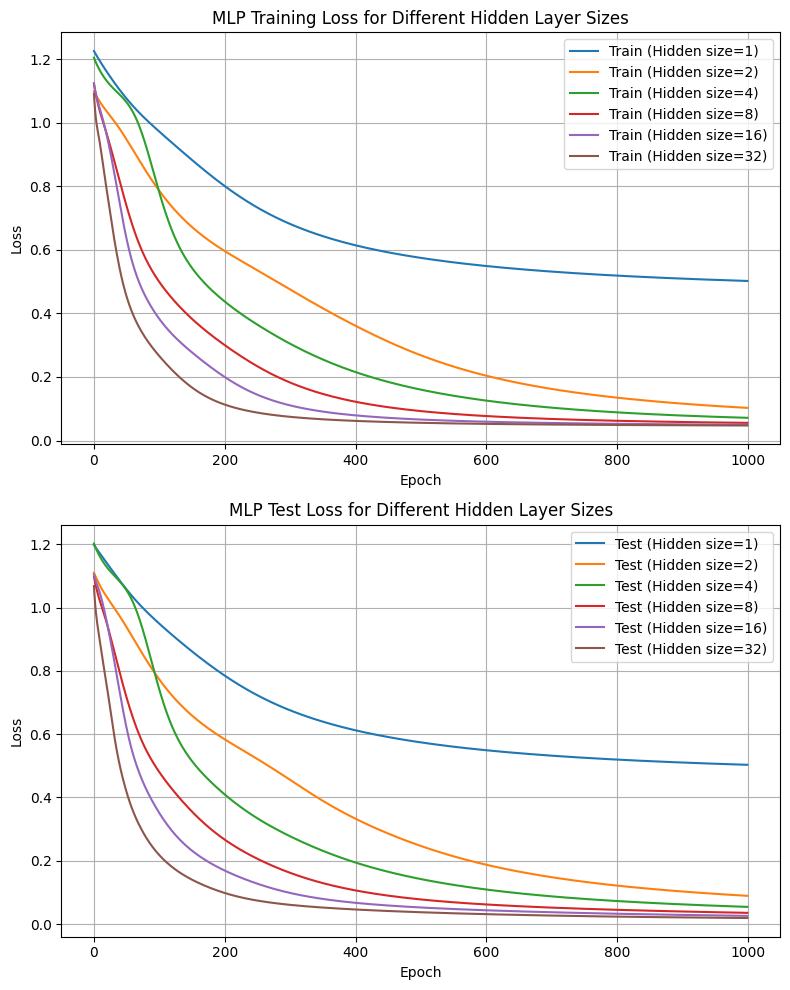

In [32]:
num_inputs = 5   
num_outputs = 3  
learning_rate = 0.005
epochs = 1000
train_lst, test_lst = [], []

train_x = train_set_1
train_y = y_train
test_x = test_set_1
test_y = y_test

#MLP model
class MLP(nn.Module):
    def __init__(self, num_inputs, num_neurons, num_outputs):
        super(MLP, self).__init__()

        self.hidden = nn.Linear(num_inputs, num_neurons, bias=False)   #we preprocesed the data in away to include a bias term
        self.output  = nn.Linear(num_neurons, num_outputs,  bias=True) 
    def forward(self, x):
        x = F.sigmoid(self.hidden(x))   
        x = self.output(x)  
        return x
 
 
train_y = train_y.long()   
test_y = test_y.long()    
 
hidden_sizes = [1, 2, 4, 8, 16, 32]
train_losses = []
test_losses = []
summary_rows = []

for num_neurons in hidden_sizes:
    model = MLP(num_inputs, num_neurons, num_outputs)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
 
    current_train_losses = []
    current_test_losses = []
 
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        pred = model(train_x.float())
        cost = F.cross_entropy(pred, train_y.squeeze(), reduction='mean')   
        cost.backward()
        optimizer.step()
        current_train_losses.append(cost.item())
    
        model.eval()
        with torch.no_grad():
            test_pred = model(test_x.float()) 
            test_cost = F.cross_entropy(test_pred, test_y.squeeze(), reduction='mean')
            current_test_losses.append(test_cost.item())
    print(test_pred, train_x)
    train_losses.append(current_train_losses)
    test_losses.append(current_test_losses)
    
    summary_rows.append(table_sumary(num_neurons,False, train_y, pred))
    summary_rows.append(table_sumary(num_neurons,True, test_y, test_pred))
  
    print(f"Hidden Size: {num_neurons}, Training Loss: {current_train_losses[-1]}, Test Loss: {current_test_losses[-1]}")

 
fig, axs = plt.subplots(2, 1, figsize=(8, 10))   
 
for i, num_neurons in enumerate(hidden_sizes):
    axs[0].plot(range(0, epochs), train_losses[i], label=f'Train (Hidden size={num_neurons})')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('MLP Training Loss for Different Hidden Layer Sizes')
axs[0].grid()
axs[0].legend()
 
for i, num_neurons in enumerate(hidden_sizes):
    axs[1].plot(range(0, epochs), test_losses[i], label=f'Test (Hidden size={num_neurons})')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('MLP Test Loss for Different Hidden Layer Sizes')
axs[1].legend()
plt.grid()
plt.tight_layout()
plt.show()

summary_tbl = pd.DataFrame(summary_rows) 

In [33]:
logit_row = {
        "model": ["Logistic Regression","Logistic Regression"],
        "hidden_neurons": [1,1],
        "test": ["train_set","test_set"],
        "accuracy": [0.9333333333333333,0.9666666666666]   
    }  
summary_tbl = pd.concat([summary_tbl, pd.DataFrame(logit_row)], ignore_index=True)
summary_tbl

,model,hidden_neurons,test,accuracy
0,MLP,1,train_set,0.675000
1,MLP,1,test_set,0.633333
2,MLP,2,train_set,0.966667
3,MLP,2,test_set,0.966667
4,MLP,4,train_set,0.983333
5,MLP,4,test_set,1.000000
6,MLP,8,train_set,0.983333
7,MLP,8,test_set,1.000000
8,MLP,16,train_set,0.983333
9,MLP,16,test_set,1.000000
